In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns
sns.set_theme(style='white', font_scale=1)

import pingouin as pg

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# load data

In [45]:
df_filtered_risidual = pd.read_pickle('output/processed_dataset/bom_tc600_cleaned_encoded_filtered_residual.pkl')
df_filtered_risidual.columns = df_filtered_risidual.columns.str.capitalize()
df_filtered_risidual.rename(columns={'Tc 600': 'TC 600'}, inplace=True)

df_filtered_risidual

No. cells per module  Wafer thickness (μm)  Number of busbars  \
1                    72.0                 179.0                3.0   
2                    60.0                 177.0                3.0   
3                   192.0                 175.0                6.0   
4                    72.0                 175.0                3.0   
5                    60.0                 175.0                3.0   
..                    ...                   ...                ...   
433                 144.0                 175.0               10.0   
436                 144.0                 175.0               10.0   
442                 120.0                 165.0               12.0   
443                  60.0                 180.0               12.0   
458                  66.0                 180.0               30.0   

     Cell height (mm)  Cell width (mm)  Front encaps thickness (mm)  \
1             156.000           156.00                         0.45   
2             156.000           156.00                         0.46   
3              95.002           158.80                         0.30   
4             164.800           156.00                         0.45   
5             156.150           156.15                         0.45   
..                ...              ...                          ...   
433            91.000           182.00                         0.65   
436            91.000           182.00                         0.65   
442            80.800           161.70                         0.50   
443           166.000           166.00                         0.55   
458           166.000           166.00                         0.55   

     Rear encaps thickness (mm)  Glass width (mm)  Glass length (mm)  \
1                          0.45             985.0             1949.0   
2                          0.47             908.8             1616.2   
3                          0.50             920.0             1913.2   
4                          0.47             988.4             1962.0   
5                          0.48             987.6             1679.8   
..                          ...               ...                ...   
433                        0.70            1128.0             2267.0   
436                        0.70            1128.0             2267.0   
442                        0.45            1024.0             1765.0   
443                        0.55            1036.0             1734.0   
458                        0.45            1036.0             1904.0   

     Glass thickness (mm)  Backsheet thickness (mm)  \
1                     4.0                    0.3500   
2                     3.2                    0.3152   
3                     3.2                    0.3236   
4                     3.2                    0.3092   
5                     3.2                    0.3130   
..                    ...                       ...   
433                   3.2                    0.3260   
436                   3.2                    0.3260   
442                   3.2                    0.3700   
443                   2.8                    0.3000   
458                   2.8                    0.3000   

     Maximum temperature tolerance (°c)  Frame thickness (mm)  \
1                                 152.6                  40.0   
2                                 138.0                  36.4   
3                                 139.0                  38.0   
4                                 123.0                  38.0   
5                                 135.0                  35.4   
..                                  ...                   ...   
433                               159.0                  40.0   
436                               159.0                  40.0   
442                               180.0                  32.0   
443                               110.0                  40.0   
458                               250.0                  40.0   

    

In [46]:
importance_df = pd.read_pickle('output/processed_dataset/shap_importance.pkl')
importance_df.rename(columns={'Si type (poly=1)': 'Mono or multi_multi'}, inplace=True)
top_features = importance_df.mean(axis=0).sort_values(ascending=False).head(10)
top_features.index.to_list()

['Mono or multi_multi',
 'Number of busbars',
 'Wafer thickness (μm)',
 'Front encaps thickness (mm)',
 'Rear encaps thickness (mm)',
 'Cell interconnect width (mm)',
 'Cell height (mm)',
 'Backsheet thickness (mm)',
 'Module area (mm2)',
 'No. cells per module']

# Stats verification of Si type

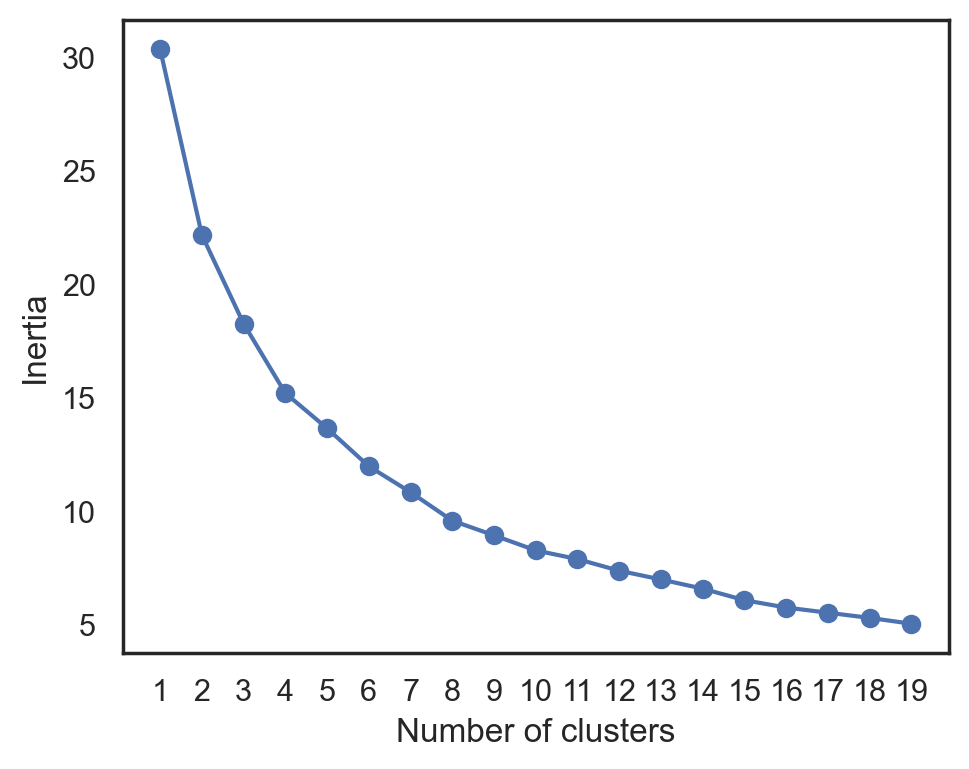

In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

feature_matrix = df_filtered_risidual[top_features.index.to_list()].drop(columns=['Mono or multi_multi'])
# standardize the feature matrix
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
# multiply feature importance to each feature
feature_matrix = feature_matrix * (top_features.drop(['Mono or multi_multi']) / top_features.drop(['Mono or multi_multi']).sum()).to_numpy()

# determine the number of clusters using elbow method
inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_matrix)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(5, 4))
plt.plot(range(1, 20), inertias, marker='o')
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()

In [48]:
kmeans = KMeans(n_clusters=2, random_state=12)
kmeans.fit(feature_matrix)
df_filtered_risidual['cluster_kmeans'] = kmeans.labels_

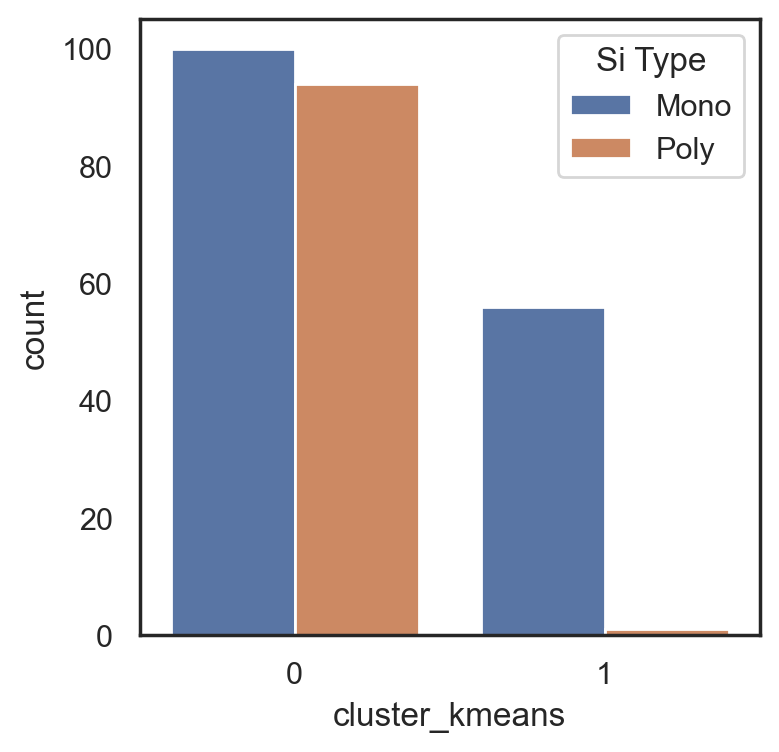

In [49]:
cell_count = df_filtered_risidual.groupby('cluster_kmeans', as_index=False)['Mono or multi_multi'].value_counts()
plt.figure(figsize=(4, 4))
ax=sns.barplot(data=cell_count, x='cluster_kmeans', y='count', hue='Mono or multi_multi')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')

Text(0.5, 1.0, 'Distribution of features from the same cluster')

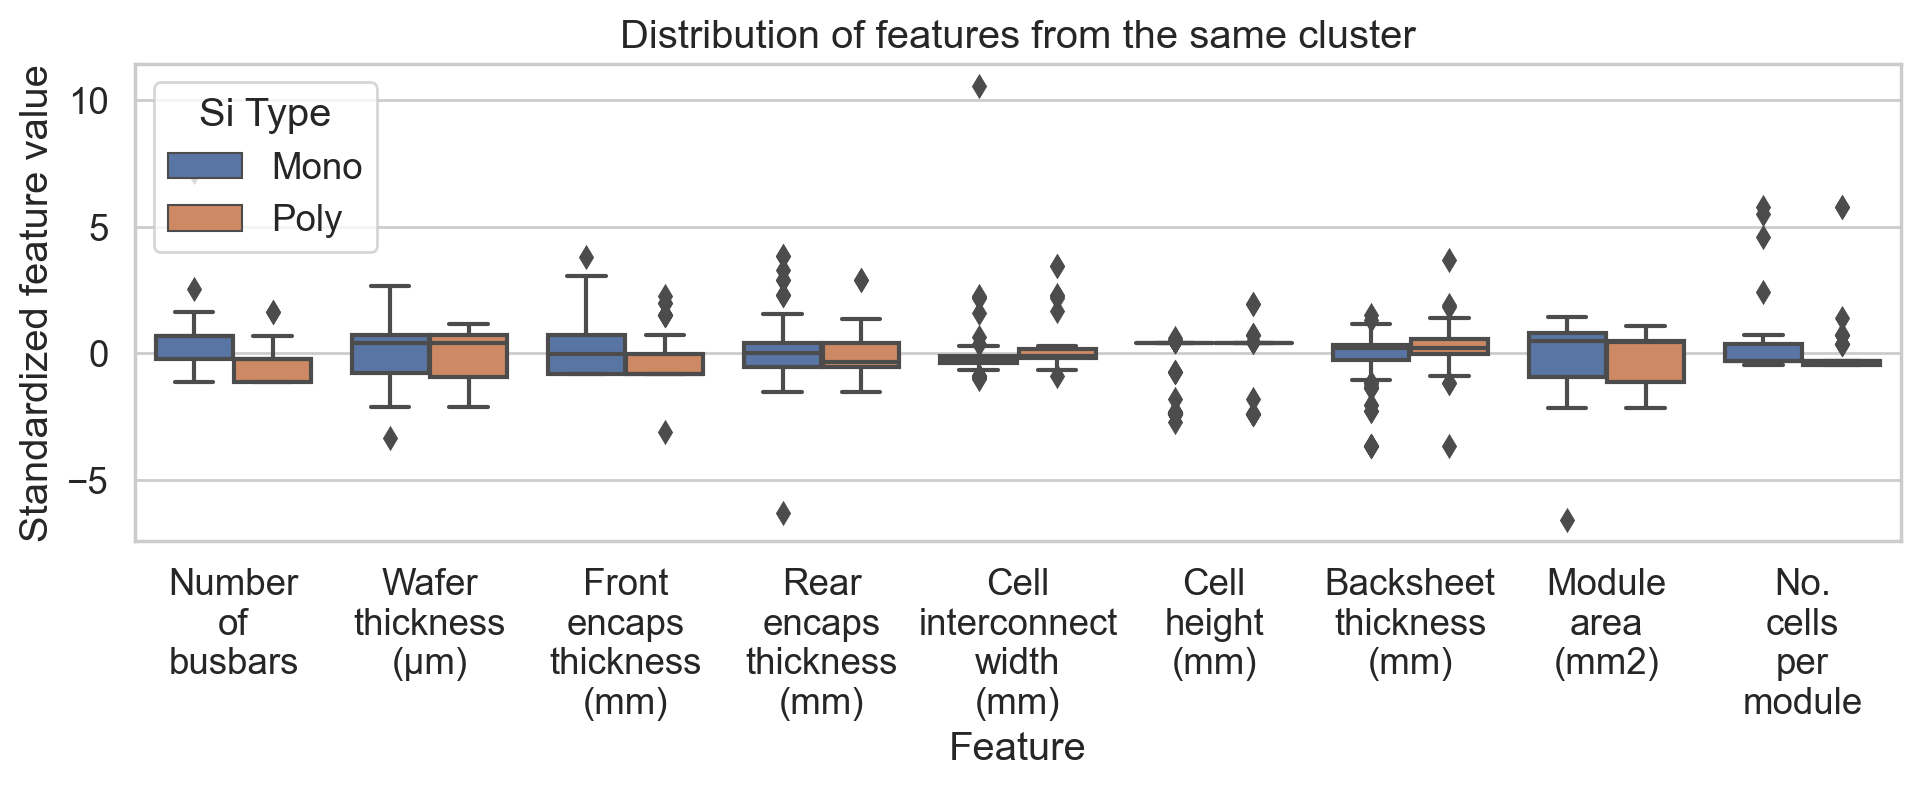

In [50]:
df_cluster_raw = df_filtered_risidual.query('cluster_kmeans==0')

df_cluster = df_cluster_raw[top_features.index.to_list()]
sns.set_theme(font_scale=1.2,style="whitegrid")
# standardize, except Mono or Multi_Multi
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()
df_cluster['Si Type'] = df_cluster_raw['Mono or multi_multi']

df_cluster = df_cluster.melt(id_vars=['Si Type'], value_vars=top_features.index.drop('Mono or multi_multi').to_list(), var_name='feature', value_name='value')

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=df_cluster, x='feature', y='value', hue='Si Type')
#change legend values. 0: mono, 1: poly
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')


# divide each xtick into multiple lines based on space in the name
plt.xlabel('Feature')
plt.ylabel('Standardized feature value')
plt.xticks(range(len(top_features.index)-1), [name.replace(' ', '\n') for name in top_features.index.drop('Mono or multi_multi')])

plt.tight_layout()
plt.title('Distribution of features from the same cluster')

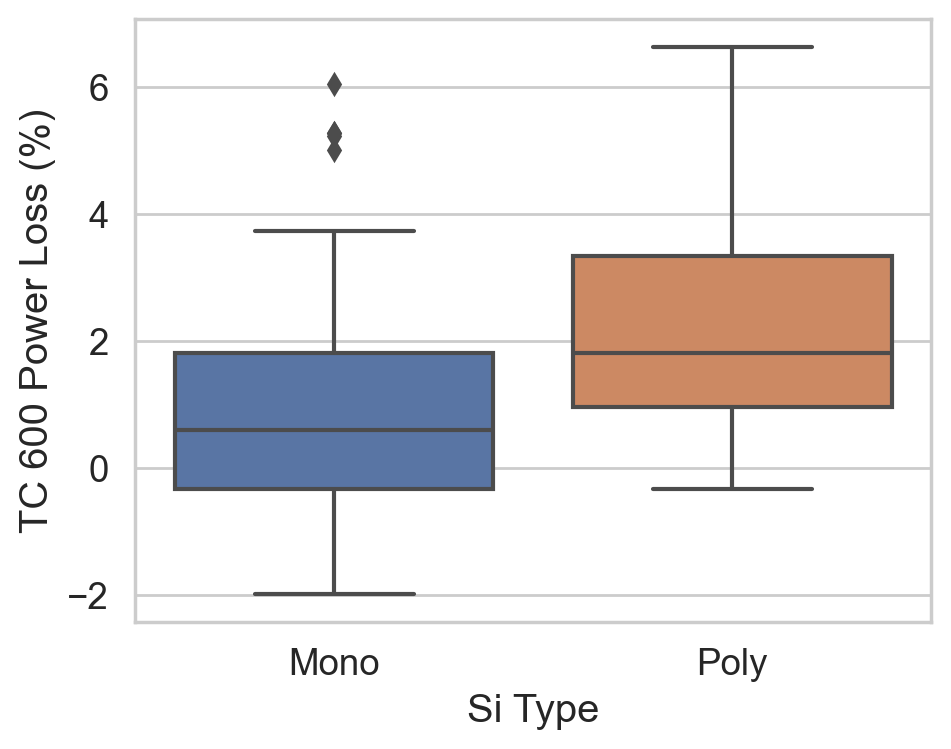

In [51]:
plt.figure(figsize=(5, 4))

sns.boxplot(data=df_filtered_risidual.query('cluster_kmeans==0'), y='TC 600', x='Mono or multi_multi')

plt.xticks([0, 1], ['Mono', 'Poly'])
plt.xlabel('Si Type')

plt.ylabel('TC 600 Power Loss (%)')

plt.tight_layout()

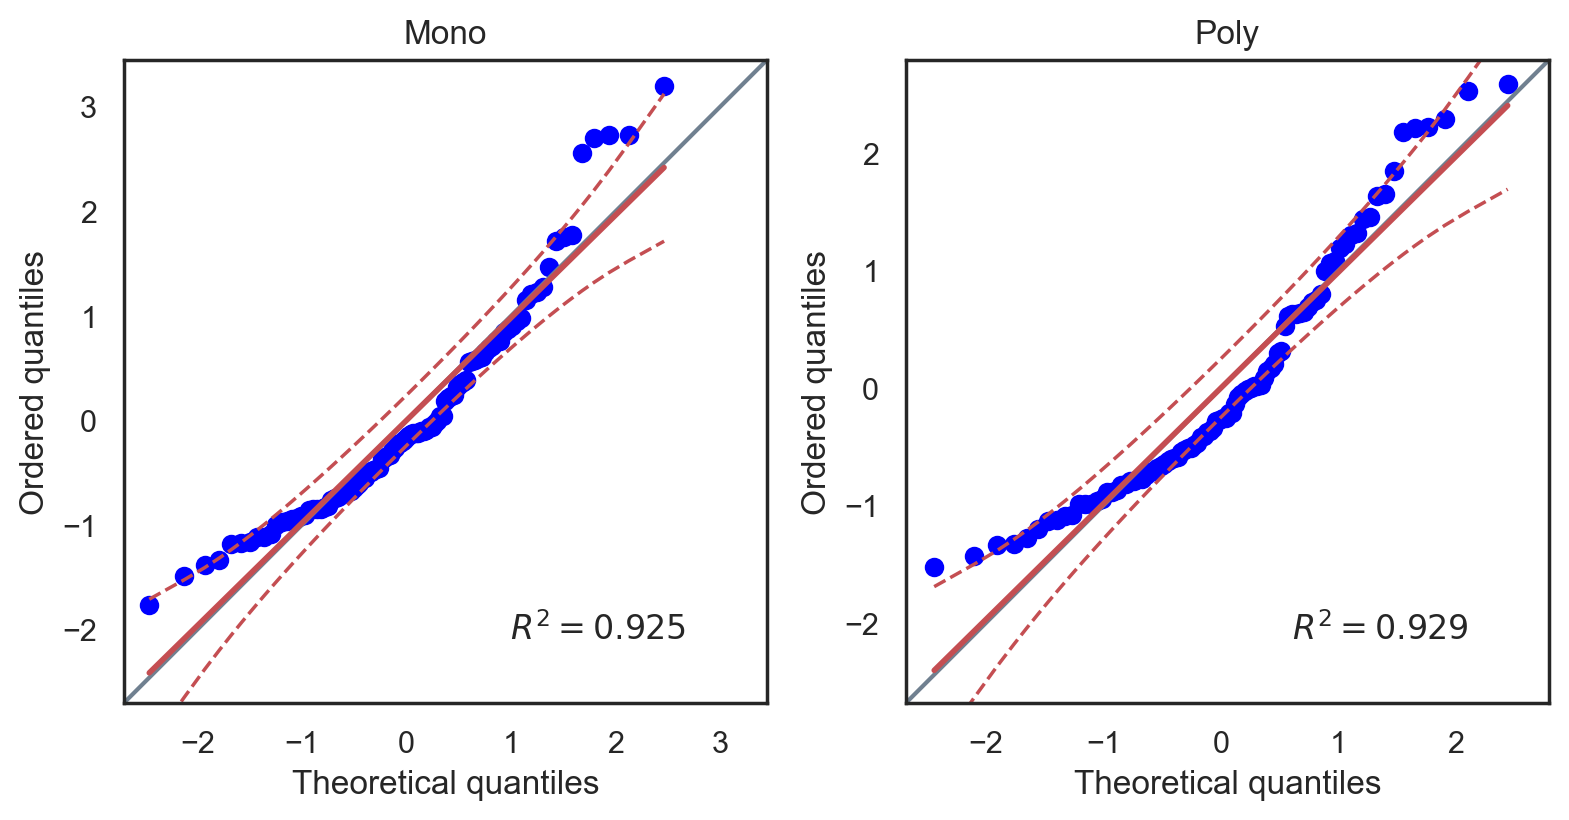

In [52]:
cluster = df_filtered_risidual.query('cluster_kmeans==0')
sns.set_theme(font_scale=1,style="white")
# qqplot of TC 600 for mono and multi separately
cluster_mono = cluster.query('`Mono or multi_multi`==0')['TC 600']
cluster_multi = cluster.query('`Mono or multi_multi`==1')['TC 600']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pg.qqplot(cluster_mono, ax=axes[0])
axes[0].set_title('Mono')

pg.qqplot(cluster_multi, ax=axes[1])
axes[1].set_title('Poly')

plt.tight_layout()

In [53]:
# t test to test if multi have higher power loss than mono

pg.ttest(cluster_mono, cluster_multi, paired=False, alternative='less')

T         dof alternative         p-val          CI95%  \
T-test -5.792885  189.817489        less  1.415517e-08  [-inf, -0.99]   

         cohen-d      BF10     power  
T-test  0.833376  7.83e+05  0.999982

# front encap

Text(0, 0.5, 'Inertia')

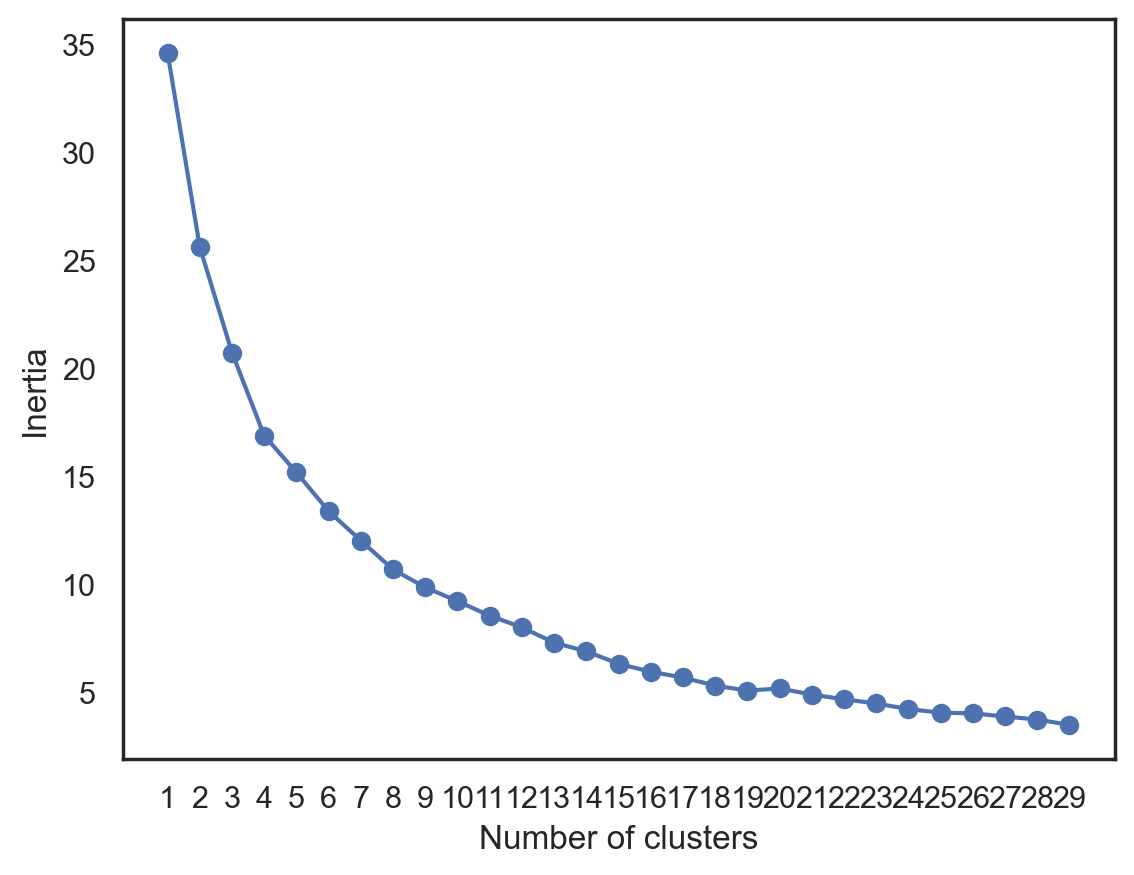

In [54]:
feature_matrix = df_filtered_risidual[top_features.index.to_list()].drop(columns=['Mono or multi_multi', 'Front encaps thickness (mm)'])
# standardize
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
# times feature importance to each feature
feature_matrix = feature_matrix * (top_features.drop(['Mono or multi_multi', 'Front encaps thickness (mm)']) / top_features.drop(['Mono or multi_multi', 'Front encaps thickness (mm)']).sum()).to_numpy()

# determine the number of clusters using elbow method
inertias = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_matrix)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 30), inertias, 'o-')
#make the xtickets interger
plt.xticks(range(1, 30))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [55]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(feature_matrix)
df_filtered_risidual['cluster_front_enc'] = kmeans.labels_

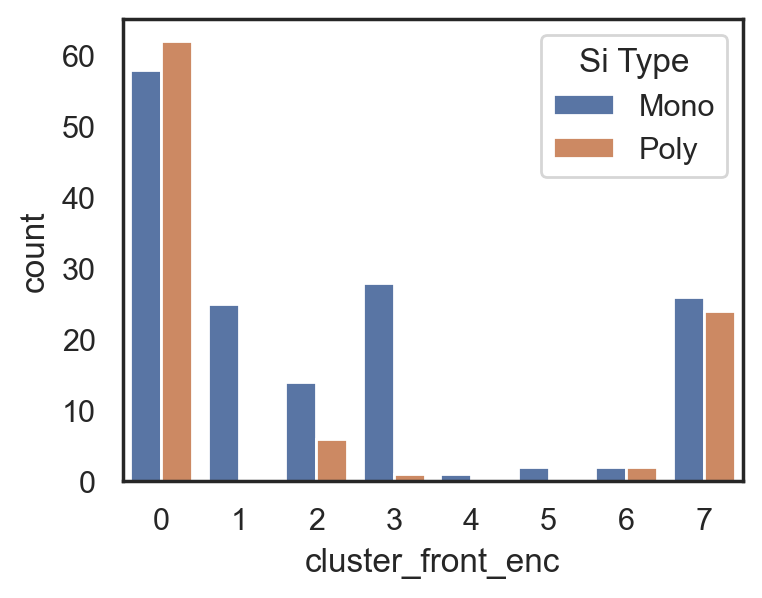

In [56]:
cell_count = df_filtered_risidual.groupby('cluster_front_enc', as_index=False)['Mono or multi_multi'].value_counts()
plt.figure(figsize=(4, 3))
ax=sns.barplot(data=cell_count, x='cluster_front_enc', y='count', hue='Mono or multi_multi')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')

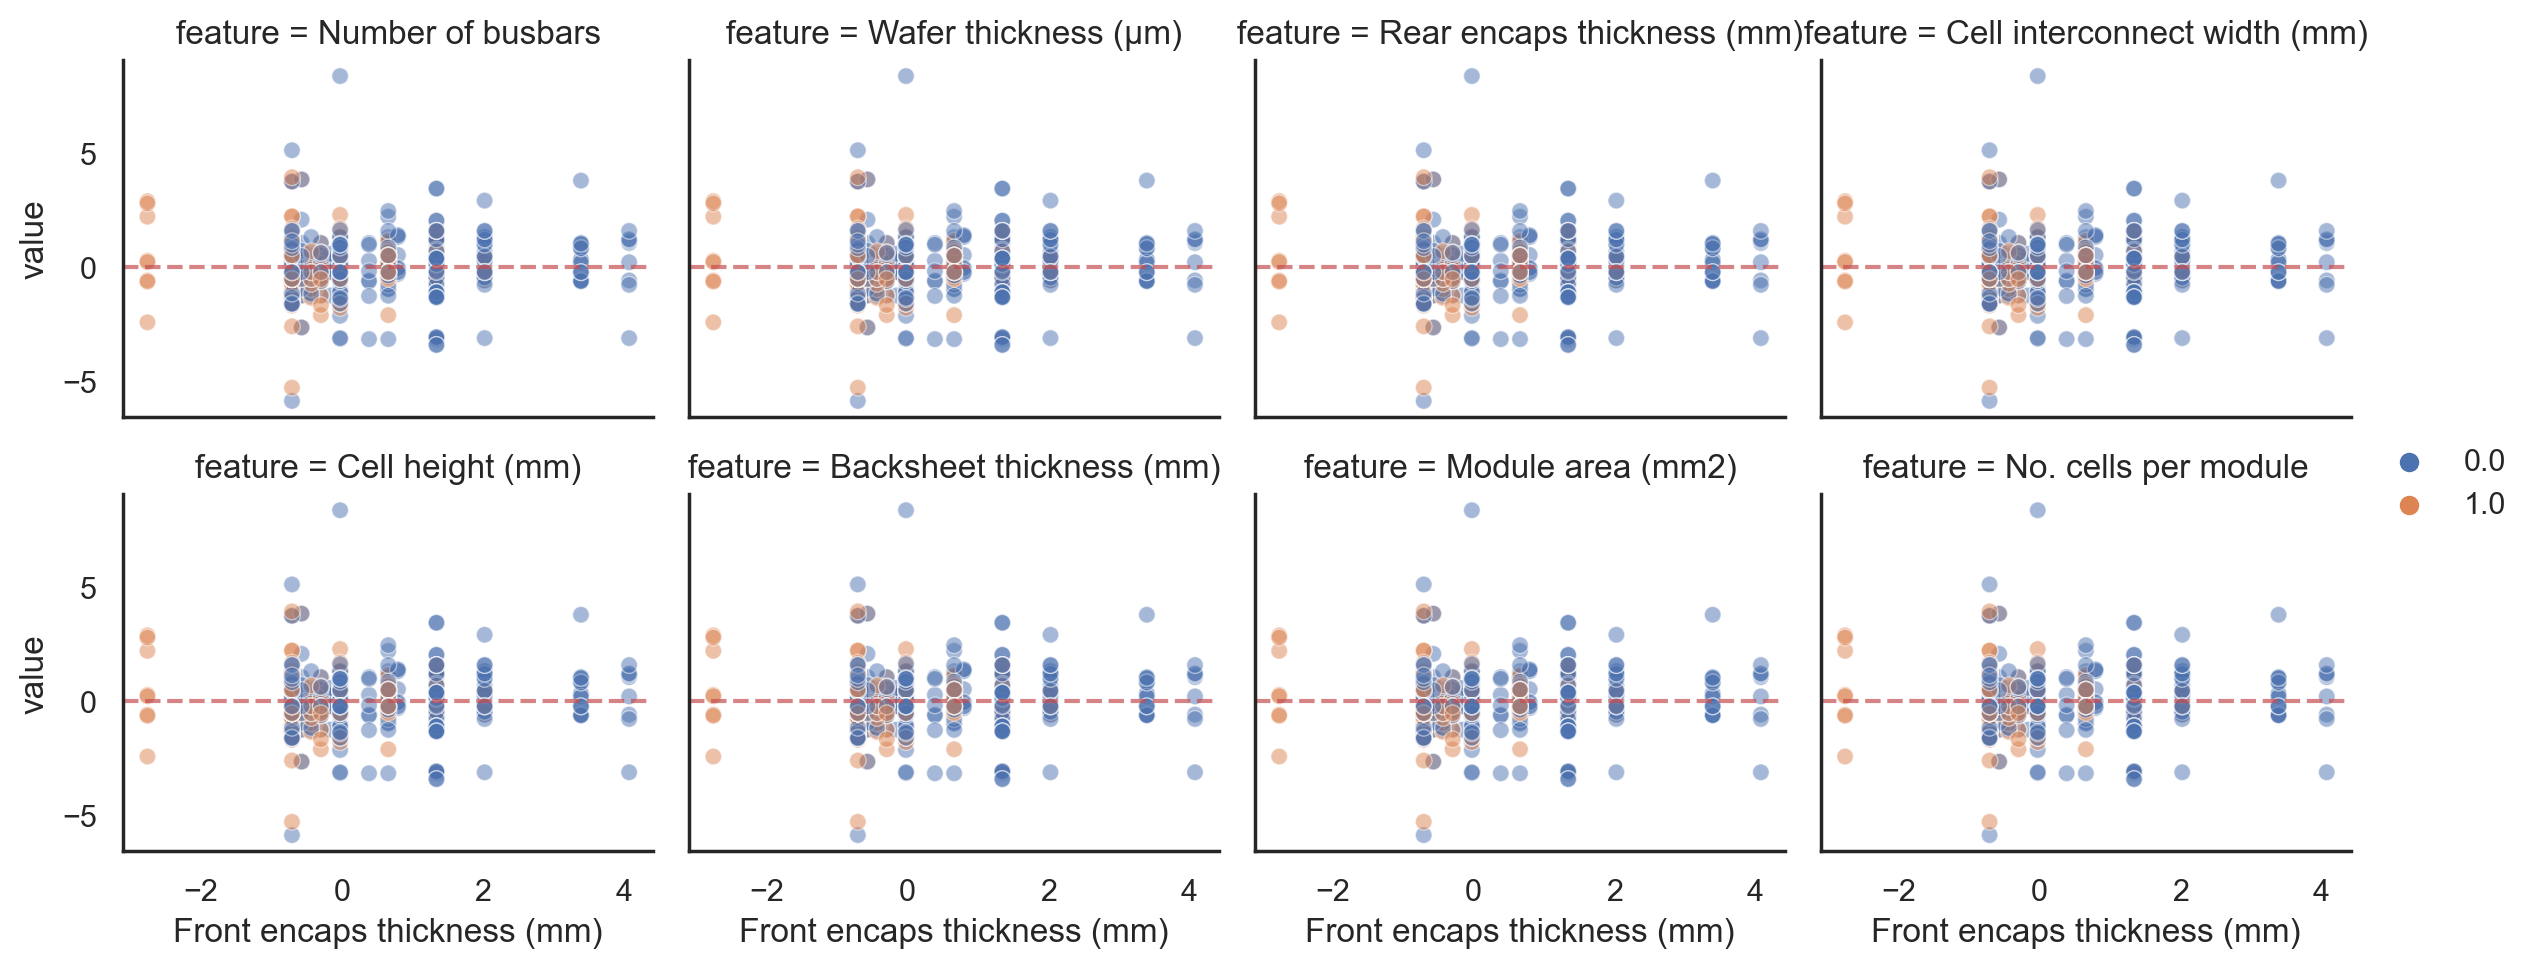

In [57]:
sns.set(font_scale=1,style="white")
df_cluster_raw = df_filtered_risidual.query('cluster_front_enc==0')

df_cluster = df_cluster_raw[top_features.index.to_list()]
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()
df_cluster['Mono or multi_multi'] = df_cluster_raw['Mono or multi_multi']

df_cluster = df_cluster.melt(id_vars=['Mono or multi_multi', 'Front encaps thickness (mm)'], 
                             value_vars=top_features.index.drop(['Mono or multi_multi', 'Front encaps thickness (mm)']).to_list(), 
                             var_name='feature', value_name='value')
# 4x4

g = sns.FacetGrid(data=df_cluster, col='feature', sharey=True, sharex=True, col_wrap=4, height=2.5, aspect=1.2)
g.map(sns.scatterplot, data=df_cluster, x='Front encaps thickness (mm)', y='value', hue = 'Mono or multi_multi', alpha=0.5)
g.add_legend()
# add hline at y=0 for each plot
for ax in g.axes:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)

n        r          CI95%     p-val     power
spearman  58 -0.15007  [-0.39, 0.11]  0.260842  0.203944

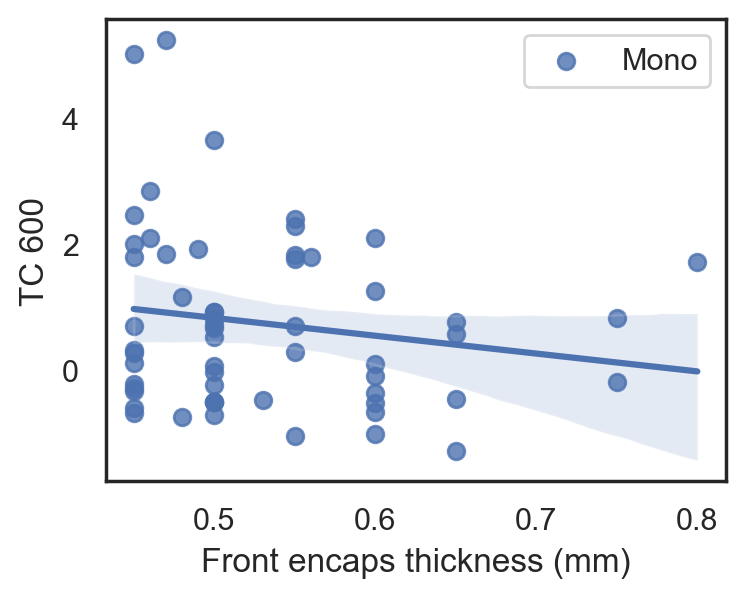

In [58]:
temp = df_filtered_risidual.query('cluster_front_enc==0 and `Mono or multi_multi`==0')
plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Front encaps thickness (mm)', y='TC 600')
plt.legend(['Mono'])

pg.corr(temp['Front encaps thickness (mm)'], temp['TC 600'], method='spearman')

n         r          CI95%     p-val     power
spearman  62 -0.142237  [-0.38, 0.11]  0.270114  0.197843

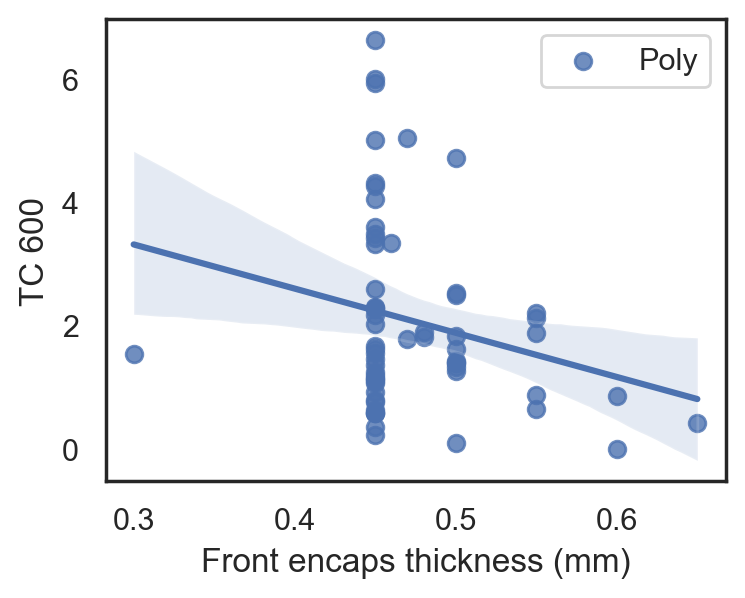

In [59]:
temp = df_filtered_risidual.query('cluster_front_enc==0 and `Mono or multi_multi`==1')
plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Front encaps thickness (mm)', y='TC 600')
plt.legend(['Poly'])

pg.corr(temp['Front encaps thickness (mm)'], temp['TC 600'], method='spearman')

# rear encap

Text(0, 0.5, 'Inertia')

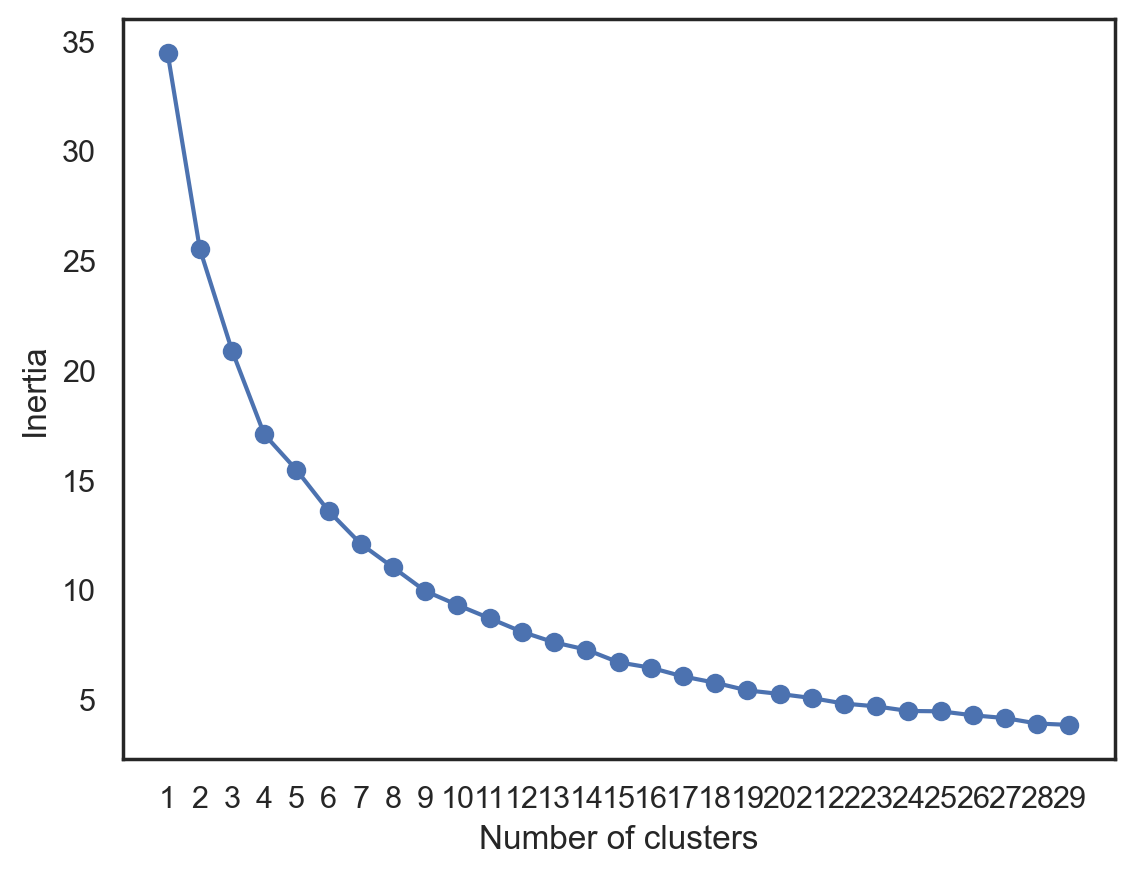

In [60]:
feature_matrix = df_filtered_risidual[top_features.index.to_list()].drop(columns=['Mono or multi_multi', 'Rear encaps thickness (mm)'])
# standardize
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
# times feature importance to each feature
feature_matrix = feature_matrix * (top_features.drop(['Mono or multi_multi', 'Rear encaps thickness (mm)']) / top_features.drop(['Mono or multi_multi', 'Rear encaps thickness (mm)']).sum()).to_numpy()

# determine the number of clusters using elbow method
inertias = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_matrix)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 30), inertias, 'o-')
#make the xtickets interger
plt.xticks(range(1, 30))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [61]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(feature_matrix)
df_filtered_risidual['cluster_rear_enc'] = kmeans.labels_

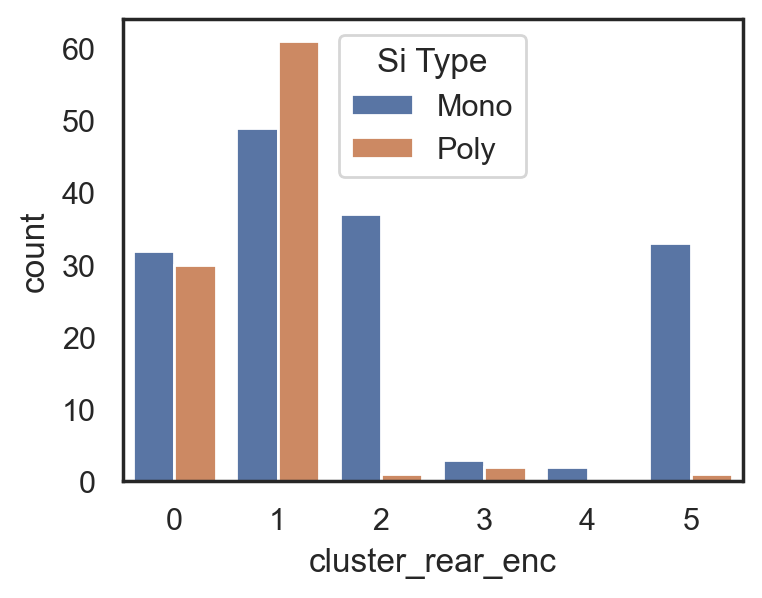

In [62]:
cell_count = df_filtered_risidual.groupby('cluster_rear_enc', as_index=False)['Mono or multi_multi'].value_counts()
plt.figure(figsize=(4, 3))

ax = sns.barplot(data=cell_count, x='cluster_rear_enc', y='count', hue='Mono or multi_multi')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')

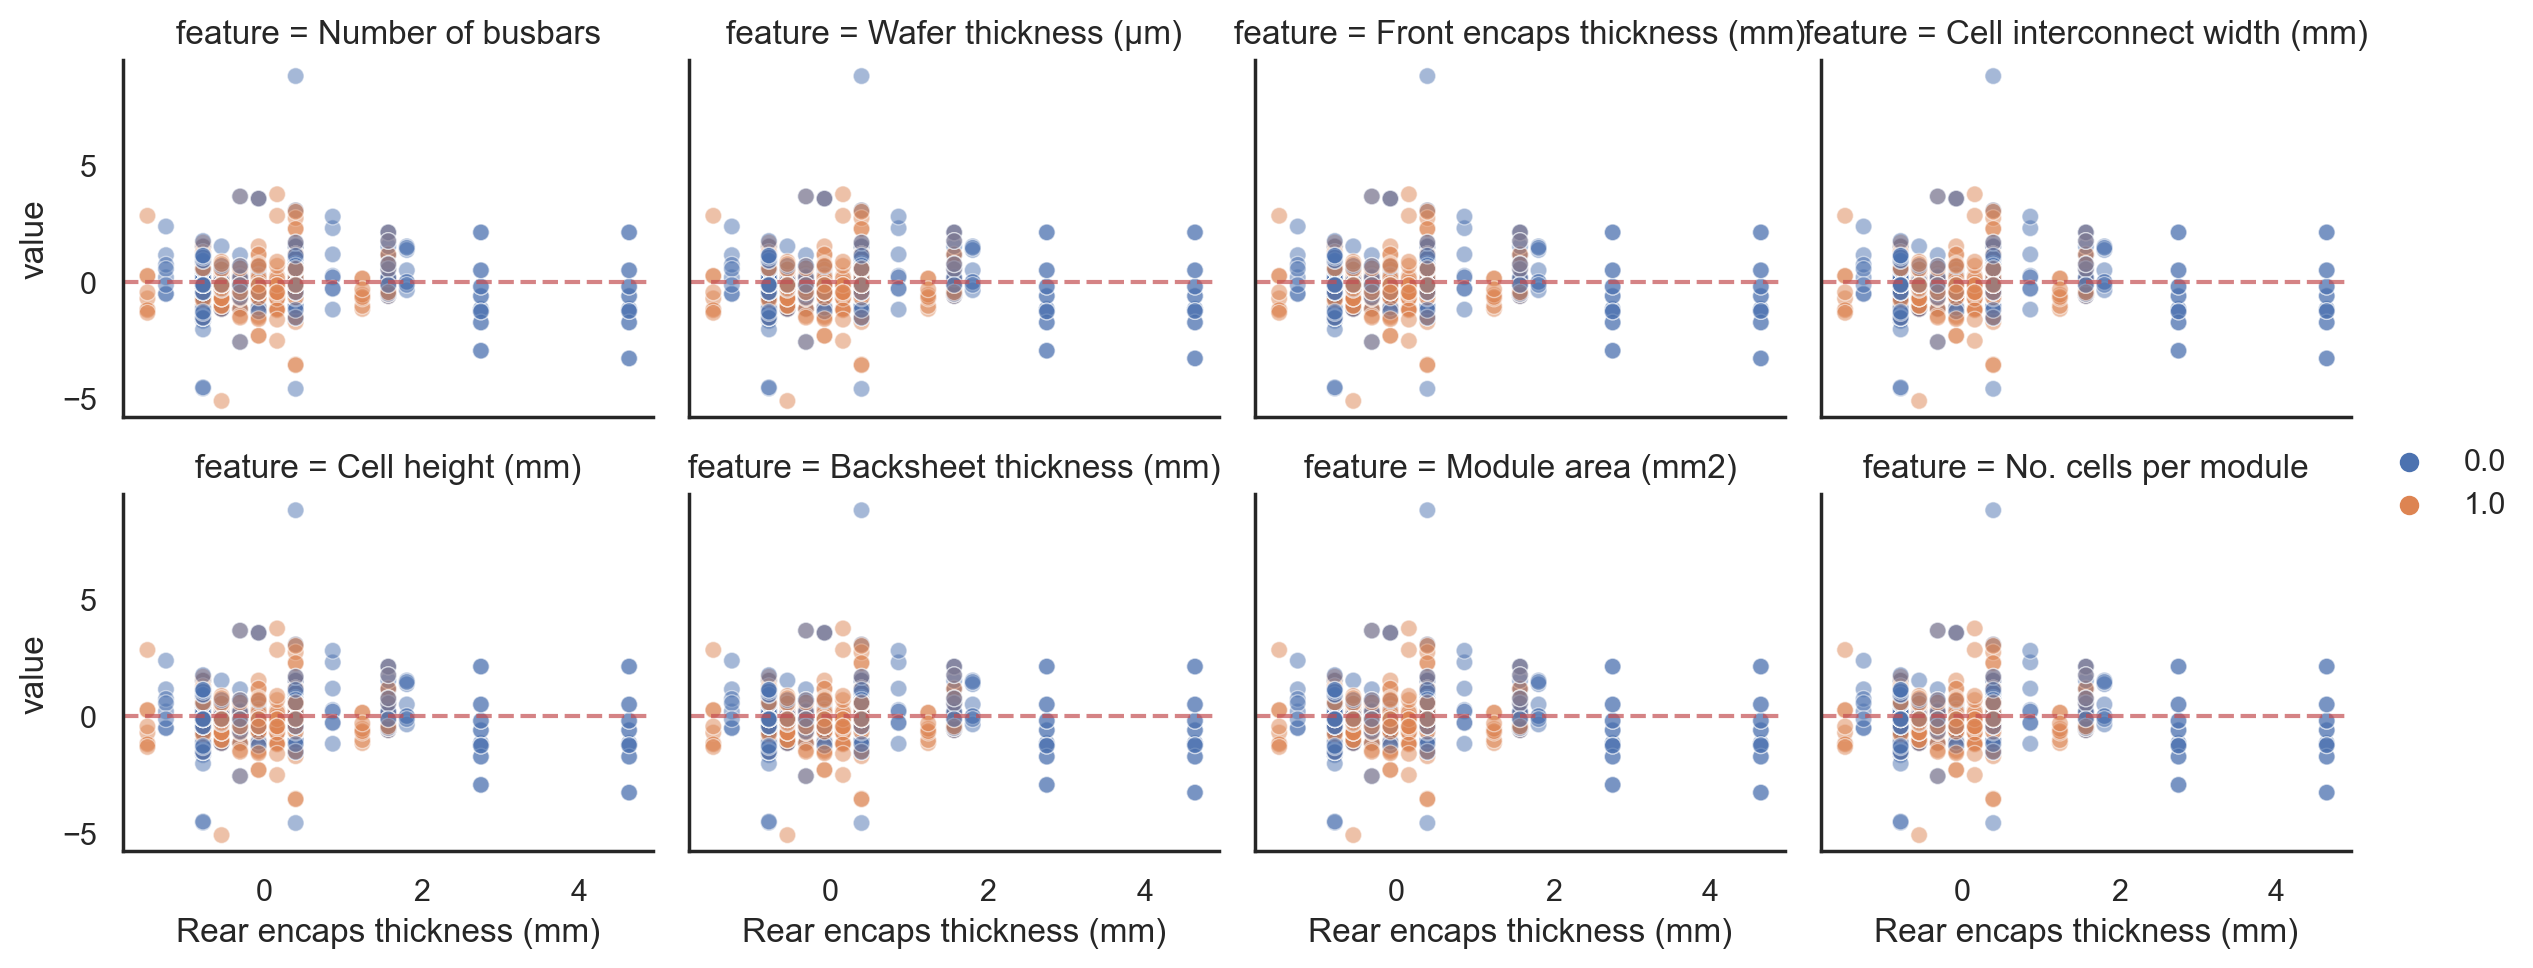

In [63]:
df_cluster_raw = df_filtered_risidual.query('cluster_rear_enc==1 and `Front encaps thickness (mm)`<0.66 and `Rear encaps thickness (mm)`>0.3')

df_cluster = df_cluster_raw[top_features.index.to_list()]
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()
df_cluster['Mono or multi_multi'] = df_cluster_raw['Mono or multi_multi']

df_cluster = df_cluster.melt(id_vars=['Mono or multi_multi', 'Rear encaps thickness (mm)'], 
                             value_vars=top_features.index.drop(['Mono or multi_multi', 'Rear encaps thickness (mm)']).to_list(), 
                             var_name='feature', value_name='value')

g = sns.FacetGrid(data=df_cluster, col='feature', sharey=True, sharex=True, col_wrap=4, height=2.5, aspect=1.2)
g.map(sns.scatterplot, data=df_cluster, x='Rear encaps thickness (mm)', y='value', hue = 'Mono or multi_multi', alpha=0.5)

g.add_legend()

for ax in g.axes:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)

n         r         CI95%    p-val     power
spearman  48 -0.249136  [-0.5, 0.04]  0.08771  0.406126

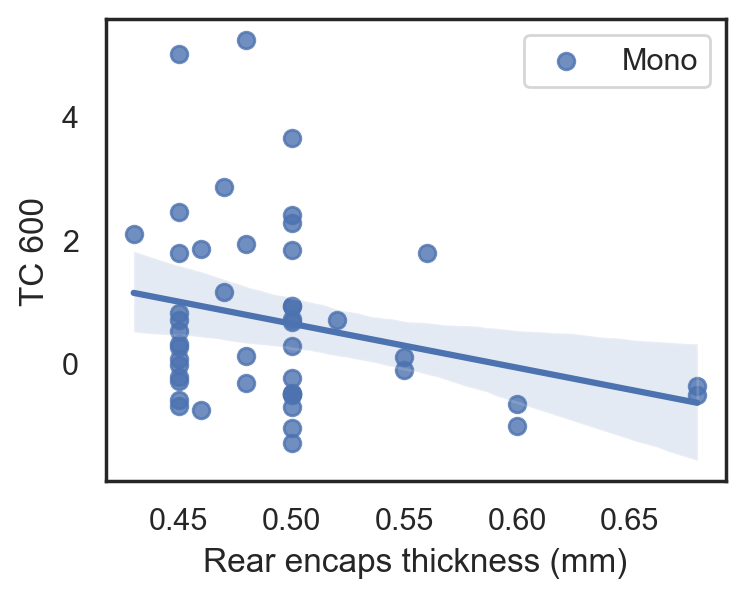

In [64]:
temp = df_filtered_risidual.query('cluster_rear_enc==1 and `Mono or multi_multi`==0 and `Rear encaps thickness (mm)`>0.3')
plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Rear encaps thickness (mm)', y='TC 600')
plt.legend(['Mono'])

pg.corr(temp['Rear encaps thickness (mm)'], temp['TC 600'], method='spearman')

n         r          CI95%     p-val     power
spearman  61 -0.090178  [-0.33, 0.17]  0.489469  0.106379

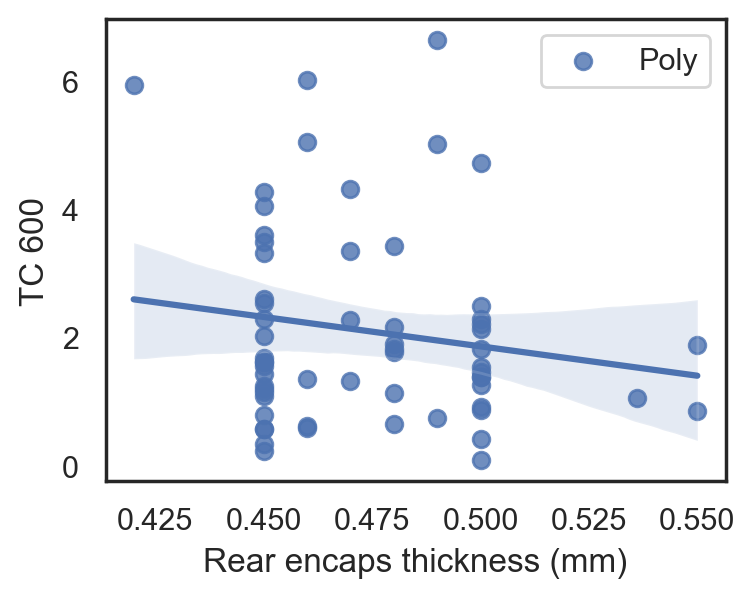

In [65]:
temp = df_filtered_risidual.query('cluster_rear_enc==1 and `Mono or multi_multi`==1')

plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Rear encaps thickness (mm)', y='TC 600')
plt.legend(['Poly'])

pg.corr(temp['Rear encaps thickness (mm)'], temp['TC 600'], method='spearman')

# backsheet

Text(0, 0.5, 'Inertia')

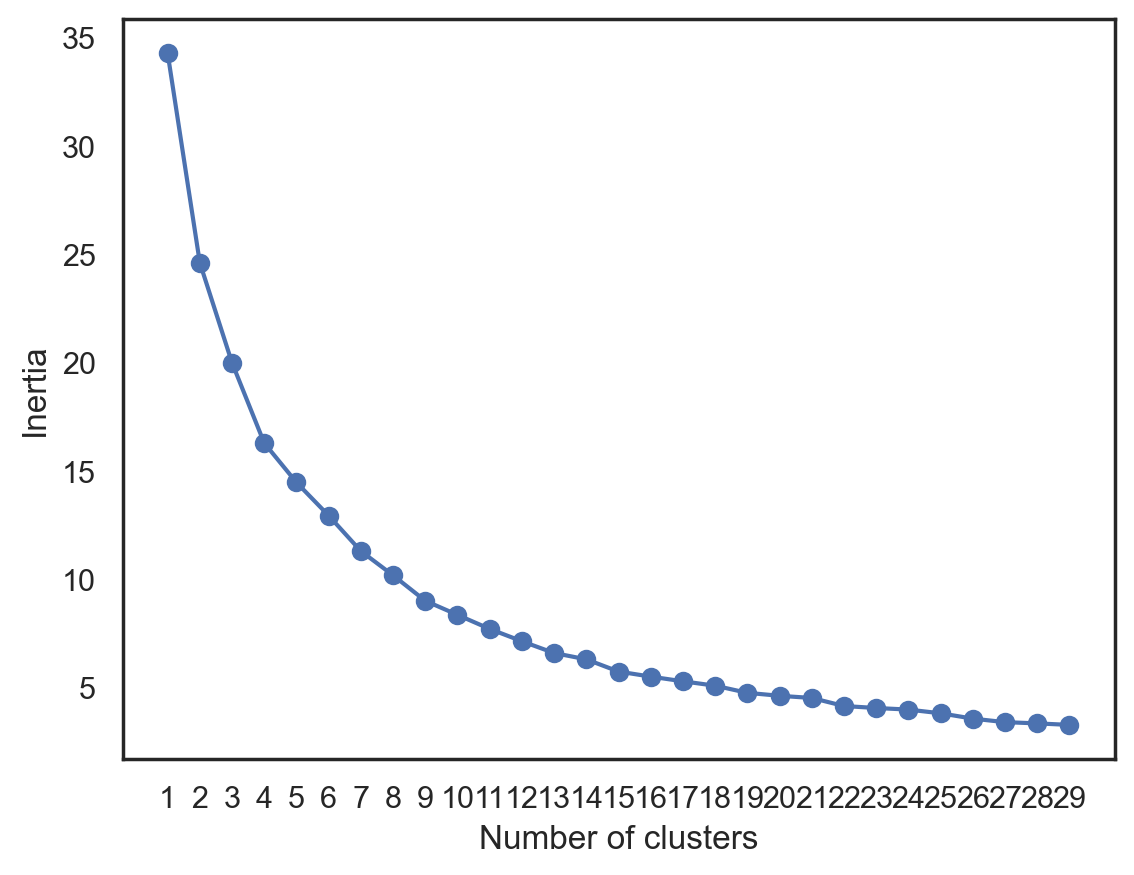

In [67]:
feature_matrix = df_filtered_risidual[top_features.index.to_list()].drop(columns=['Mono or multi_multi', 'Backsheet thickness (mm)'])
# standardize
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
# times feature importance to each feature
feature_matrix = feature_matrix * (top_features.drop(['Mono or multi_multi', 'Backsheet thickness (mm)']) / top_features.drop(['Mono or multi_multi', 'Backsheet thickness (mm)']).sum()).to_numpy()

# determine the number of clusters using elbow method
inertias = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_matrix)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 30), inertias, 'o-')
#make the xtickets interger
plt.xticks(range(1, 30))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

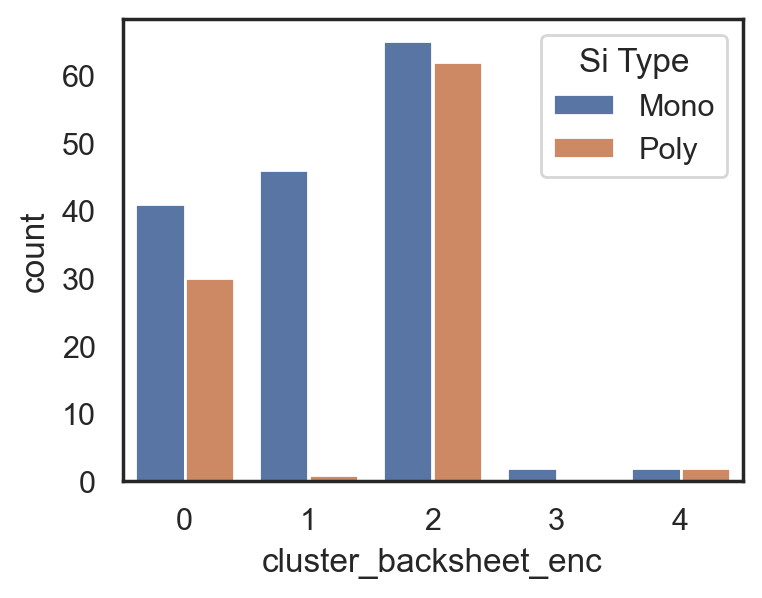

In [68]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(feature_matrix)
df_filtered_risidual['cluster_backsheet_enc'] = kmeans.labels_

cell_count = df_filtered_risidual.groupby('cluster_backsheet_enc', as_index=False)['Mono or multi_multi'].value_counts()
plt.figure(figsize=(4, 3))
ax=sns.barplot(data=cell_count, x='cluster_backsheet_enc', y='count', hue='Mono or multi_multi')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')

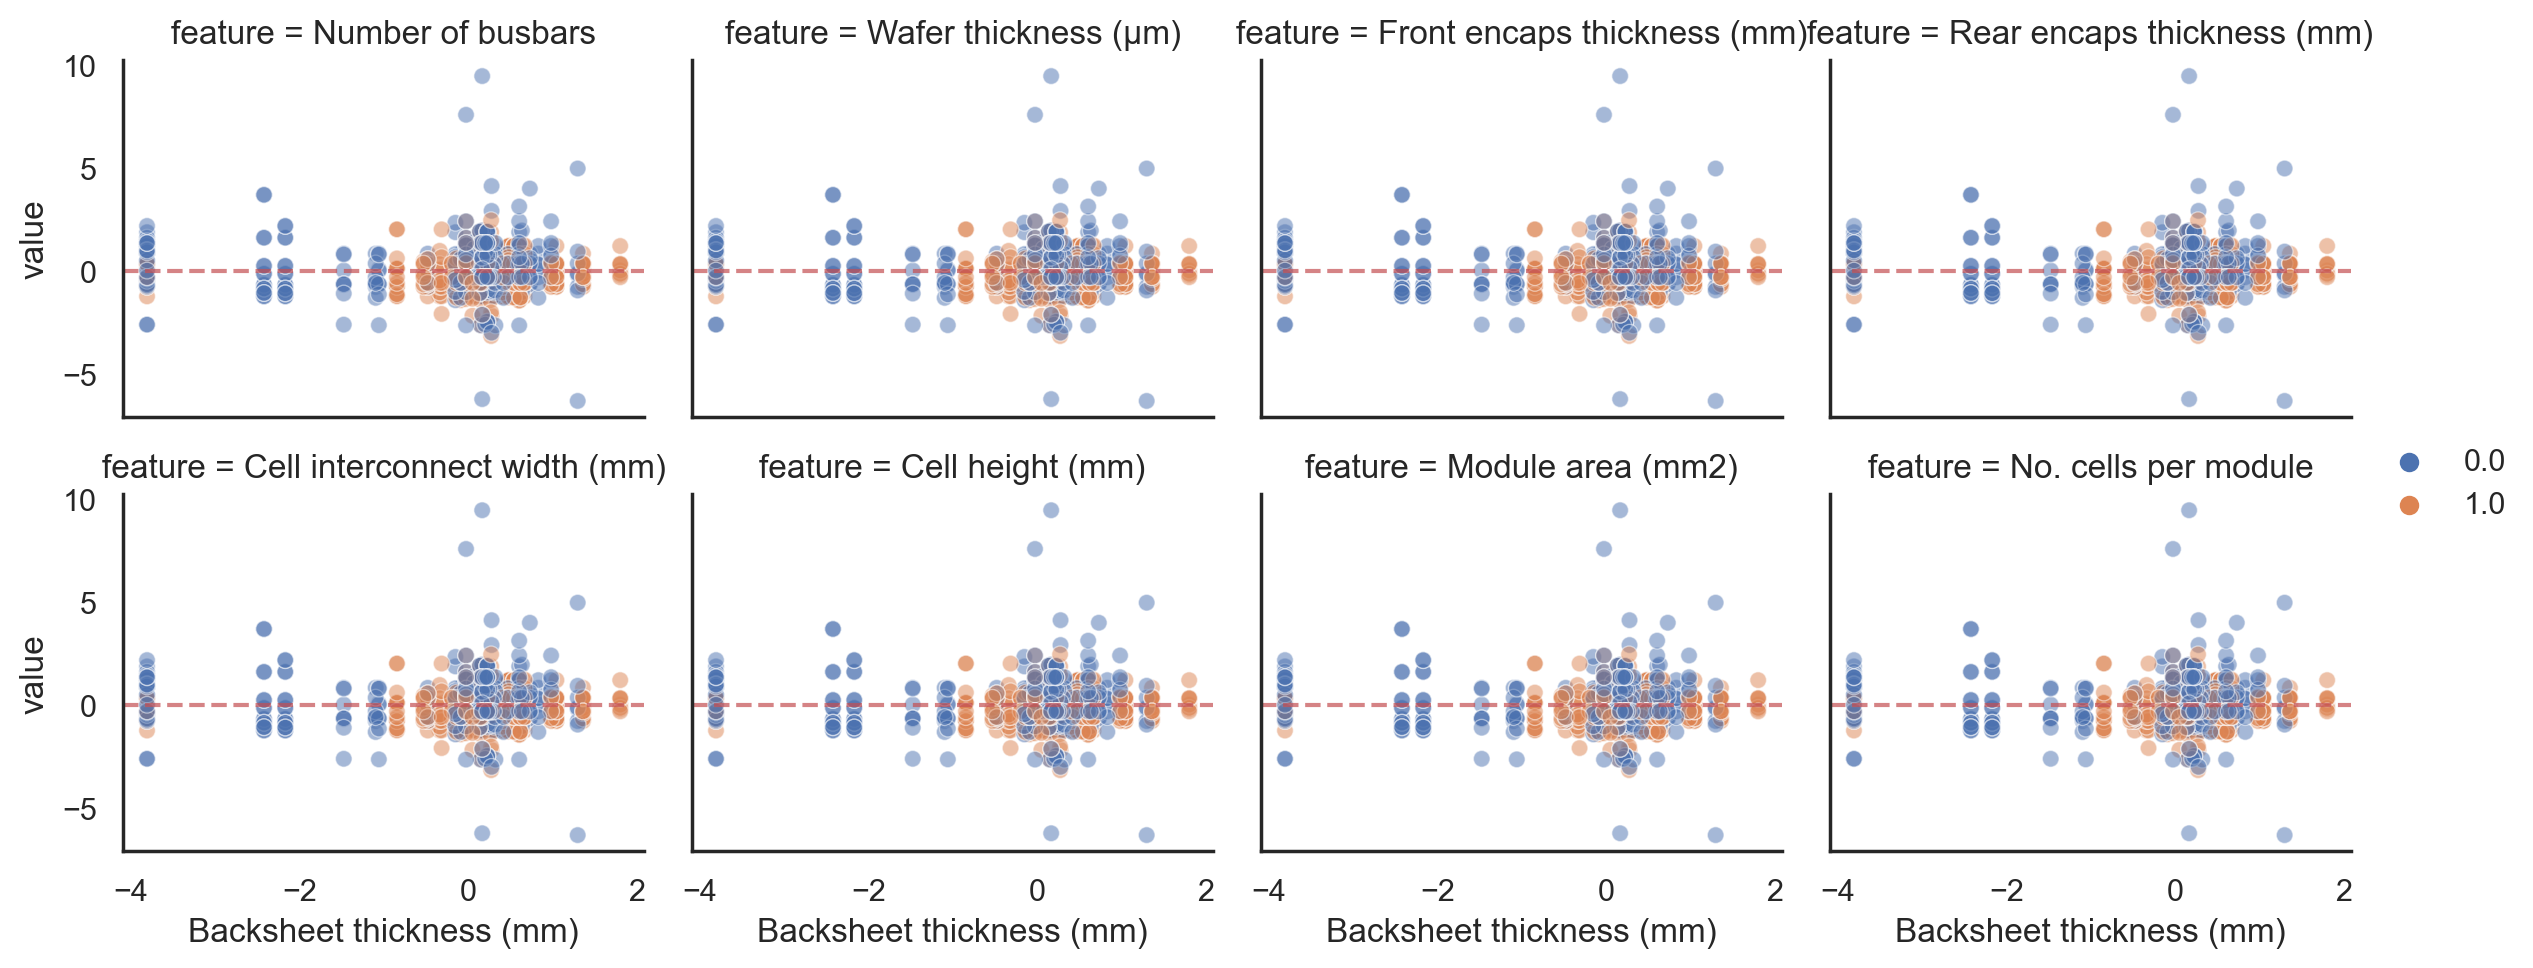

In [69]:
df_cluster_raw = df_filtered_risidual.query('cluster_backsheet_enc==2')

df_cluster = df_cluster_raw[top_features.index.to_list()]
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()
df_cluster['Mono or multi_multi'] = df_cluster_raw['Mono or multi_multi']

df_cluster = df_cluster.melt(id_vars=['Mono or multi_multi', 'Backsheet thickness (mm)'], 
                             value_vars=top_features.index.drop(['Mono or multi_multi', 'Backsheet thickness (mm)']).to_list(), 
                             var_name='feature', value_name='value')

# 4x4

g = sns.FacetGrid(data=df_cluster, col='feature', sharey=True, sharex=True, col_wrap=4, height=2.5, aspect=1.2)
g.map(sns.scatterplot, data=df_cluster, x='Backsheet thickness (mm)', y='value', hue = 'Mono or multi_multi', alpha=0.5)

g.add_legend()



# add hline at y=0 for each plot
for ax in g.axes:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)

n         r          CI95%     p-val     power
spearman  61  0.175602  [-0.08, 0.41]  0.175843  0.274799

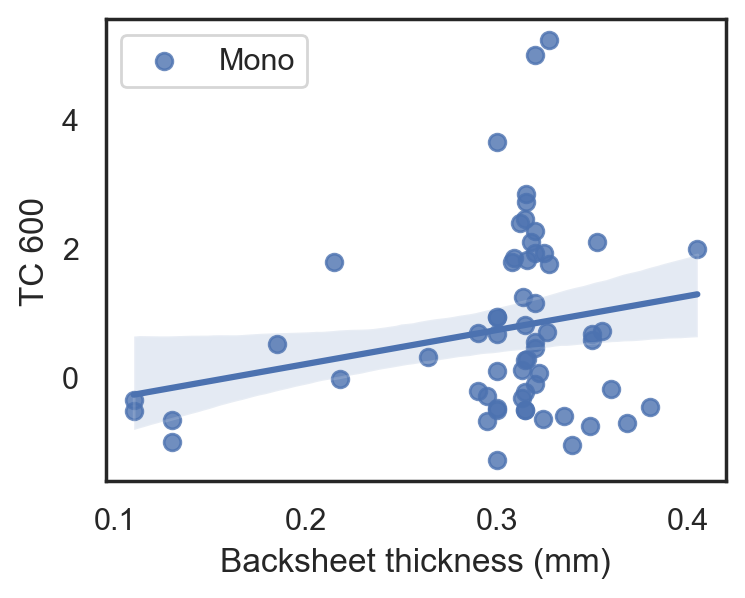

In [70]:
temp = df_filtered_risidual.query('cluster_backsheet_enc==2 and `Mono or multi_multi`==0 and `Backsheet thickness (mm)`>0')
plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Backsheet thickness (mm)', y='TC 600')
plt.legend(['Mono'])

pg.corr(temp['Backsheet thickness (mm)'], temp['TC 600'], method='spearman')

n         r           CI95%     p-val     power
spearman  61 -0.260768  [-0.48, -0.01]  0.042378  0.534797

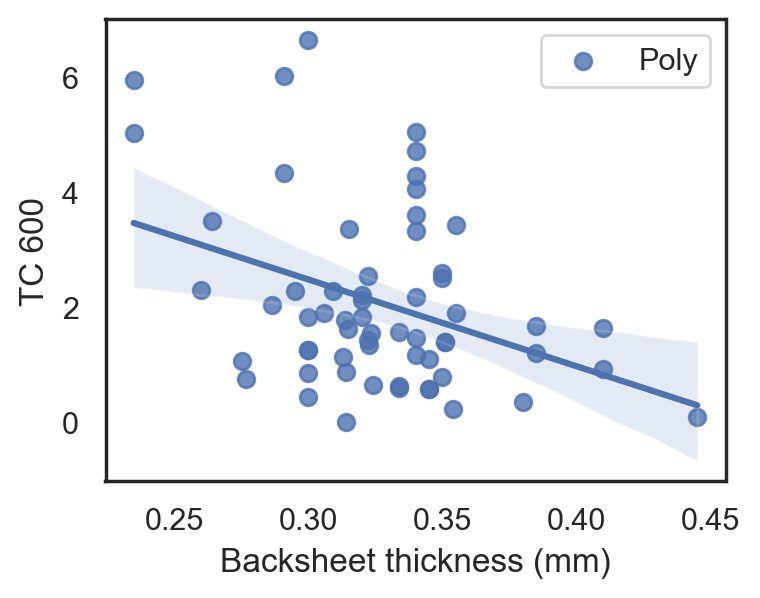

In [71]:
temp = df_filtered_risidual.query('cluster_backsheet_enc==2 and `Mono or multi_multi`==1 and `Backsheet thickness (mm)`>0')

plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Backsheet thickness (mm)', y='TC 600')
plt.legend(['Poly'])

pg.corr(temp['Backsheet thickness (mm)'], temp['TC 600'], method='spearman')

# wafer thickness

Text(0, 0.5, 'Inertia')

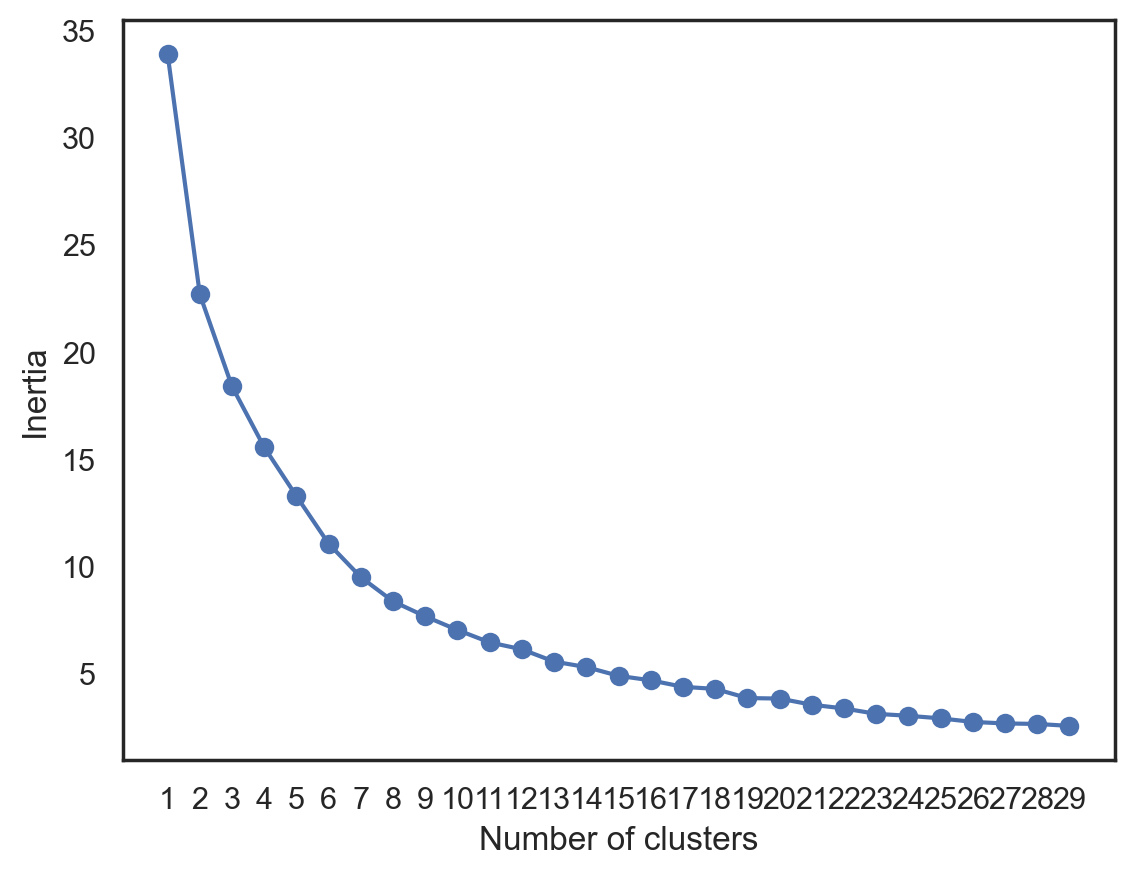

In [72]:
feature_matrix = df_filtered_risidual[top_features.index.to_list()].drop(columns=['Mono or multi_multi', 'Wafer thickness (μm)'])
# standardize
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
# times feature importance to each feature
feature_matrix = feature_matrix * (top_features.drop(['Mono or multi_multi', 'Wafer thickness (μm)']) / top_features.drop(['Mono or multi_multi', 'Wafer thickness (μm)']).sum()).to_numpy()

# determine the number of clusters using elbow method
inertias = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(feature_matrix)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 30), inertias, 'o-')
#make the xtickets interger
plt.xticks(range(1, 30))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

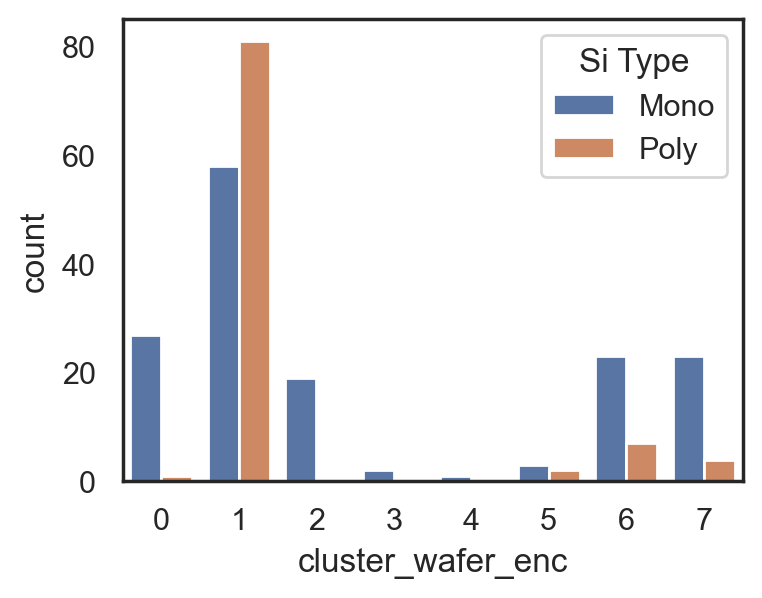

In [73]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(feature_matrix)
df_filtered_risidual['cluster_wafer_enc'] = kmeans.labels_

cell_count = df_filtered_risidual.groupby('cluster_wafer_enc', as_index=False)['Mono or multi_multi'].value_counts()
plt.figure(figsize=(4, 3))
ax=sns.barplot(data=cell_count, x='cluster_wafer_enc', y='count', hue='Mono or multi_multi')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Mono', 'Poly'], title='Si Type')

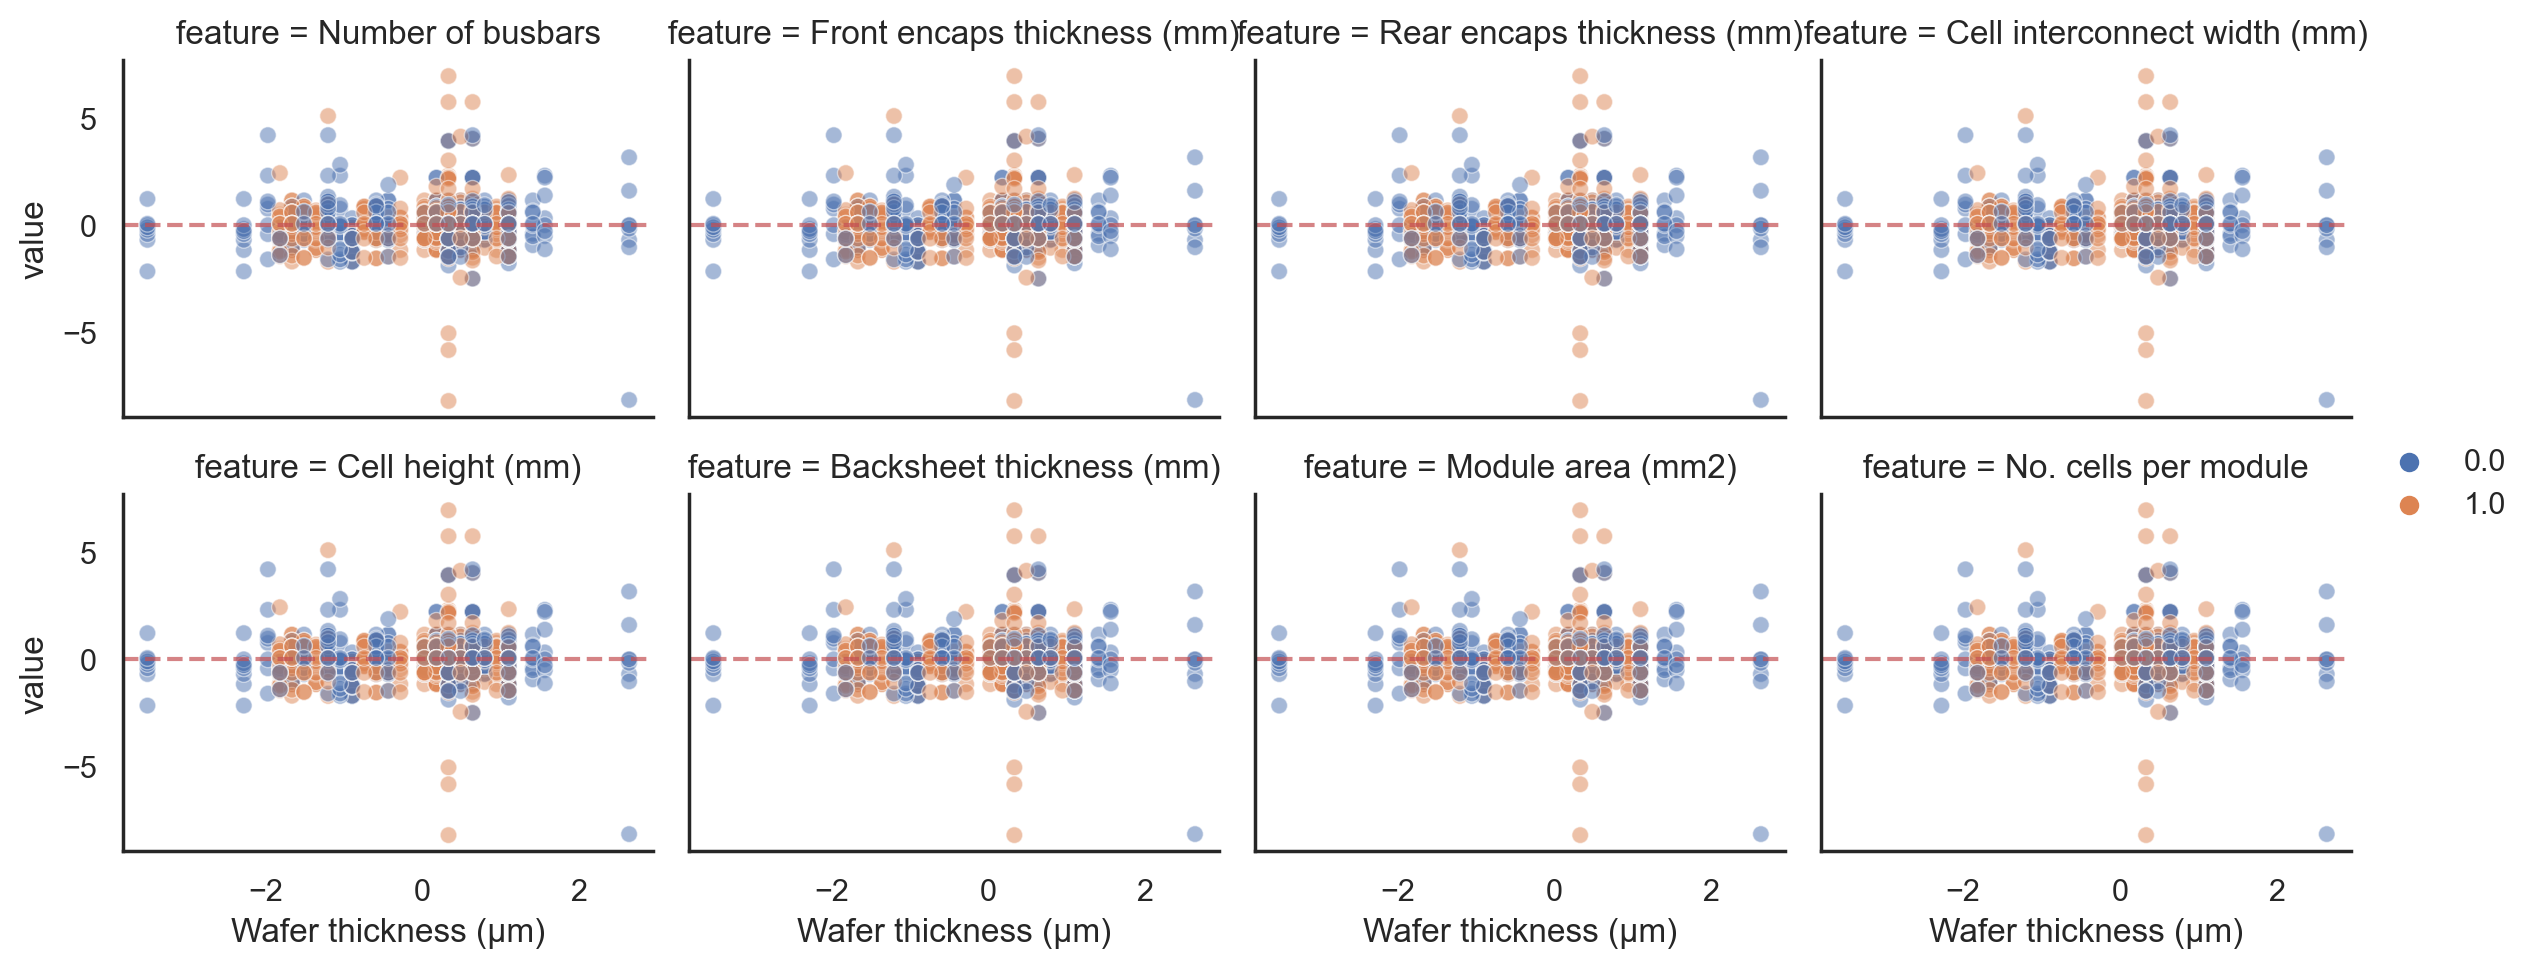

In [74]:
df_cluster_raw = df_filtered_risidual.query('cluster_wafer_enc==1')

df_cluster = df_cluster_raw[top_features.index.to_list()]
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()
df_cluster['Mono or multi_multi'] = df_cluster_raw['Mono or multi_multi']

df_cluster = df_cluster.melt(id_vars=['Mono or multi_multi', 'Wafer thickness (μm)'], 
                             value_vars=top_features.index.drop(['Mono or multi_multi', 'Wafer thickness (μm)']).to_list(), 
                             var_name='feature', value_name='value')

# 4x4

g = sns.FacetGrid(data=df_cluster, col='feature', sharey=True, sharex=True, col_wrap=4, height=2.5, aspect=1.2)
g.map(sns.scatterplot, data=df_cluster, x='Wafer thickness (μm)', y='value', hue = 'Mono or multi_multi', alpha=0.5)

g.add_legend()

for ax in g.axes:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)

n        r          CI95%     p-val     power
spearman  58 -0.01056  [-0.27, 0.25]  0.937291  0.050441

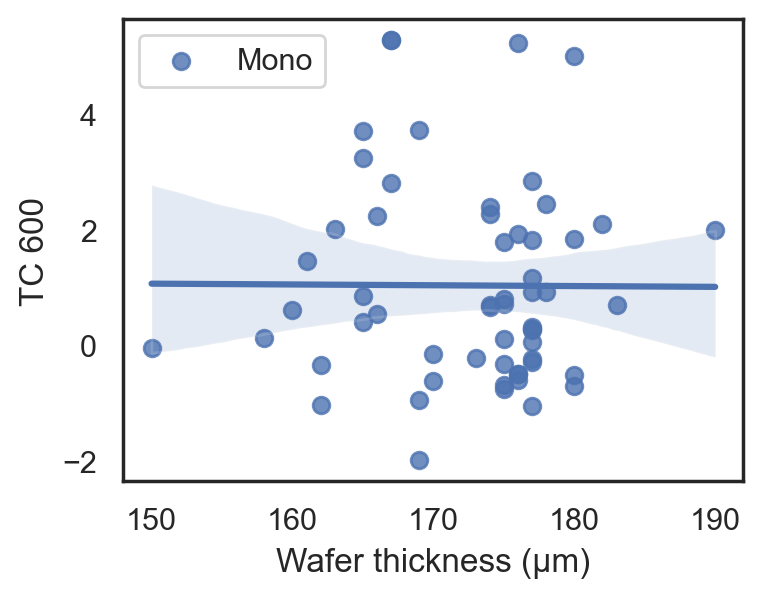

In [76]:
temp = df_filtered_risidual.query('cluster_wafer_enc==1 and `Mono or multi_multi`==0')
plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Wafer thickness (μm)', y='TC 600')
plt.legend(['Mono'])
pg.corr(temp['Wafer thickness (μm)'], temp['TC 600'], method='spearman')

n         r           CI95%     p-val     power
spearman  81 -0.268454  [-0.46, -0.05]  0.015385  0.685689

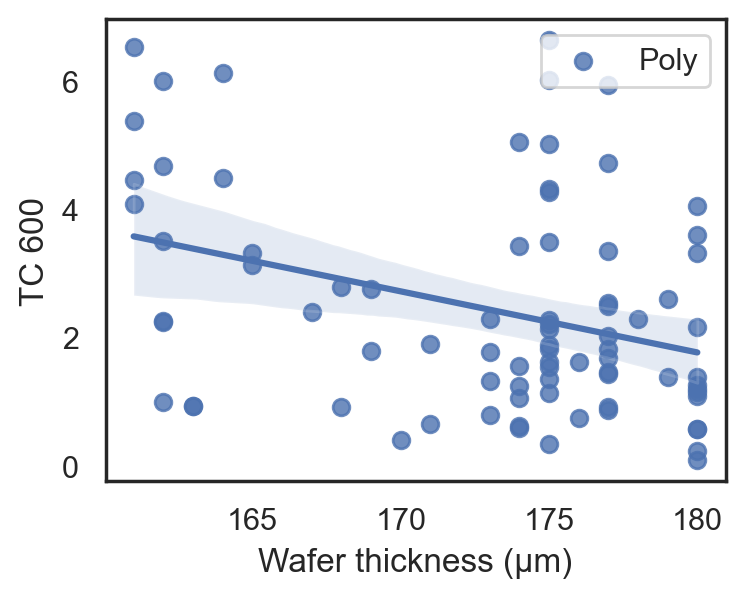

In [77]:
temp = df_filtered_risidual.query('cluster_wafer_enc==1 and `Mono or multi_multi`==1')

plt.figure(figsize=(4, 3))
sns.regplot(data=temp, x='Wafer thickness (μm)', y='TC 600')
plt.legend(['Poly'], loc='upper right')

pg.corr(temp['Wafer thickness (μm)'], temp['TC 600'], method='spearman')